# Training a Graph Neural Network (GNN)

This notebook demonstrates how to train a multitask GNN, specifically a Recurrent Graph Convolutional Network (RGCN), on the HJ Andrews watershed graph to predict both dry (0) or wet (1) status and mean daily stream discharge (in cubic meters per second). Two model variants are provided:

- **RGCN v0**: Operational version used in USGS river-dl projects (6h² + 4h additional params)
- **RGCN v1**: Simplified published version by Jia et al. 2020 (h² + h additional params)
- **RGCN v2**: Shared encoder with separate regression/classification heads and lambda-weighted multitask loss

The model combines:
1. **Temporal processing** via LSTM gates to capture time-series dynamics
2. **Spatial aggregation** via graph convolution using the river network adjacency matrix

**⚠️ Computational Requirements:**
- This model is computationally expensive and **requires a GPU** for training
- Our model was trained on [X] NVIDIA [GPU Model] GPUs with [X] GB VRAM
- Estimated training time: [X] hours on the above hardware
- CPU-only training is not recommended due to the graph convolution operations

## Setup and imports


In [2]:
from __future__ import annotations

import pickle
from pathlib import Path
from typing import Any, Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml

# Set device to GPU (force CUDA)
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please ensure GPU drivers and CUDA are properly installed.")

device = torch.device("cuda:0")  # Use first GPU
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"Memory reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")


Using device: cuda:0
GPU: NVIDIA RTX A6000
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB


## Load configuration

In [3]:
DATA_ROOT = Path("/data/kripat/usgs-gnn")
CONFIG_PATH = DATA_ROOT / "configs/rgcn_config.yaml"

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

MODEL_VERSION = config["model"]["version"]

print("Loaded configuration:")
for section, params in config.items():
    print(f"\n[{section}]")
    if isinstance(params, dict):
        for k, v in params.items():
            print(f"  {k}: {v}")
    else:
        print(f"  {params}")


Loaded configuration:

[paths]
  data_root: /data/kripat/usgs-gnn
  graph_pickle: graph_builder/graph/hja_graph.gpickle
  edge_index: graph_builder/graph/hja_edge_index.npz
  checkpoints_dir: checkpoints/rgcn
  logs_dir: logs/rgcn

[model]
  version: v2
  input_dim: 11
  hidden_dim: 64
  dropout: 0.1
  recur_dropout: 0.0
  return_states: False

[training]
  epochs: 100
  batch_size: 1586
  seq_length: 28
  lambda_discharge: 0.5
  lambda_wetdry: 1.0
  learning_rate: 0.001
  weight_decay: 0.0001
  grad_clip: 1.0
  early_stopping_patience: 20
  seed: 42

[data]
  train_ratio: 0.7
  val_ratio: 0.15
  test_ratio: 0.15
  start_date: 1980-01-01
  end_date: 2020-12-31
  target_col: value
  normalize: True
  driver_features: None

[logging]
  log_interval: 1
  save_interval: 1
  use_tensorboard: True


## Load the graph and build adjacency matrix


In [4]:
import networkx as nx

GRAPH_PATH = DATA_ROOT / config["paths"]["graph_pickle"]

if not GRAPH_PATH.exists():
    raise FileNotFoundError(
        f"Graph not found at {GRAPH_PATH}. "
        "Please run build_graph.ipynb first to create the graph."
    )

with open(GRAPH_PATH, "rb") as f:
    graph = pickle.load(f)

print(f"Loaded graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")

# Get ordered list of node IDs (consistent ordering is critical for adjacency alignment)
node_ids = sorted(graph.nodes())
node_to_idx = {nid: idx for idx, nid in enumerate(node_ids)}
n_segments = len(node_ids)

print(f"Number of segments: {n_segments}")
print(f"Sample node IDs: {node_ids[:5]}")


Loaded graph with 793 nodes and 780 edges
Number of segments: 793
Sample node IDs: [55000900026515, 55000900027171, 55000900027172, 55000900027173, 55000900027174]


In [5]:
def build_adjacency_matrix(graph: nx.DiGraph, node_ids: list) -> np.ndarray:
    """Build adjacency matrix from graph edges.
    
    The adjacency matrix A is constructed such that A[i,j] = 1 if there is
    an edge from node j to node i (i.e., j influences i in graph convolution).
    
    For downstream flow: edge (u, v) means u flows to v, so A[v,u] = 1.
    """
    n = len(node_ids)
    node_to_idx = {nid: idx for idx, nid in enumerate(node_ids)}
    
    adj = np.zeros((n, n), dtype=np.float32)
    
    for u, v in graph.edges():
        if u in node_to_idx and v in node_to_idx:
            i = node_to_idx[v]  # destination
            j = node_to_idx[u]  # source
            adj[i, j] = 1.0
    
    # Optionally add self-loops (uncomment if needed)
    # adj += np.eye(n, dtype=np.float32)
    
    # Row-normalize (each row sums to 1, or 0 if no connections)
    row_sums = adj.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    adj_normalized = adj / row_sums
    
    return adj_normalized


adj_matrix = build_adjacency_matrix(graph, node_ids)
print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Non-zero entries: {np.count_nonzero(adj_matrix)}")
print(f"Sparsity: {1 - np.count_nonzero(adj_matrix) / adj_matrix.size:.4f}")


Adjacency matrix shape: (793, 793)
Non-zero entries: 780
Sparsity: 0.9988


## RGCN Model Definitions


In [6]:
class RGCN_v0(nn.Module):
    """
    RGCN version 0: The operational version with separate update gates for 
    combining temporal (LSTM) and spatial (graph) information.
    
    Key difference from v1: Uses separate update mechanisms for hidden and 
    cell states, requiring more parameters but allowing more flexibility.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        adj_matrix: np.ndarray,
        output_dim: int = 1,
        recur_dropout: float = 0.0,
        dropout: float = 0.0,
        return_states: bool = False,
        device: str = "cpu",
        seed: Optional[int] = None,
    ):
        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        super().__init__()

        # Adjacency matrix: A[i,j] = weight from segment j to segment i
        self.register_buffer("A", torch.from_numpy(adj_matrix).float())

        # Graph convolution parameters for hidden state
        self.W_graph_h = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_graph_h = nn.Parameter(torch.Tensor(hidden_dim))

        # Graph convolution parameters for cell state
        self.W_graph_c = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_graph_c = nn.Parameter(torch.Tensor(hidden_dim))

        # Update gate parameters for hidden state
        self.W_h_cur = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.W_h_prev = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_h = nn.Parameter(torch.Tensor(hidden_dim))

        # Update gate parameters for cell state
        self.W_c_cur = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.W_c_prev = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_c = nn.Parameter(torch.Tensor(hidden_dim))

        # Standard LSTM parameters
        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.output_dim = output_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))

        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)
        self.dense = nn.Linear(hidden_dim, output_dim)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(
        self, x: torch.Tensor, init_states: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
    ) -> torch.Tensor:
        bs, seq_sz, _ = x.size()
        hidden_seq = []

        if init_states is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
            c_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size

        for t in range(seq_sz):
            x_t = x[:, t, :]

            # Standard LSTM gate computations
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t = torch.sigmoid(gates[:, :HS])
            f_t = torch.sigmoid(gates[:, HS : HS * 2])
            g_t = torch.tanh(gates[:, HS * 2 : HS * 3])
            o_t = torch.sigmoid(gates[:, HS * 3 :])

            c_t_cur = f_t * c_t + i_t * self.recur_dropout(g_t)
            h_t_cur = o_t * torch.tanh(c_t)

            # Spatial aggregation via graph convolution
            h_graph_t = torch.tanh(self.A @ (h_t @ self.W_graph_h + self.b_graph_h))
            c_graph_t = torch.tanh(self.A @ (c_t @ self.W_graph_c + self.b_graph_c))

            # Combine temporal and spatial information
            h_t = torch.sigmoid(h_t_cur @ self.W_h_cur + h_graph_t @ self.W_h_prev + self.b_h)
            c_t = torch.sigmoid(c_t_cur @ self.W_c_cur + c_graph_t @ self.W_c_prev + self.b_c)

            hidden_seq.append(h_t.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)

        if self.return_states:
            return out, (h_t, c_t)
        return out


In [7]:
class RGCN_v1(nn.Module):
    """
    RGCN version 1: Simplified published version with fewer parameters.
    
    Key difference from v0: Spatial information (via q^{t-1}) is added directly 
    to the cell state update rather than through separate update gates.
    This requires significantly fewer parameters: h² + h vs 6h² + 4h for v0.
    
    Reference: https://doi.org/10.1137/1.9781611976700.69
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        adj_matrix: np.ndarray,
        output_dim: int = 1,
        recur_dropout: float = 0.0,
        dropout: float = 0.0,
        return_states: bool = False,
        device: str = "cpu",
        seed: Optional[int] = None,
    ):
        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        super().__init__()

        self.register_buffer("A", torch.from_numpy(adj_matrix).float())

        # Spatial feature parameters (only graph-specific params in v1)
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        # Standard LSTM parameters
        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.output_dim = output_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))

        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)
        self.dense = nn.Linear(hidden_dim, output_dim)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(
        self, x: torch.Tensor, init_states: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
    ) -> torch.Tensor:
        bs, seq_sz, _ = x.size()
        hidden_seq = []

        if init_states is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
            c_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size

        for t in range(seq_sz):
            x_t = x[:, t, :]

            # Standard LSTM gate computations
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t = torch.sigmoid(gates[:, :HS])
            f_t = torch.sigmoid(gates[:, HS : HS * 2])
            g_t = torch.tanh(gates[:, HS * 2 : HS * 3])
            o_t = torch.sigmoid(gates[:, HS * 3 :])

            # Spatial feature learning
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)

            # Cell state update with spatial information added directly
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)

            # Hidden state update
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)

        if self.return_states:
            return out, (h_t, c_t)
        return out


In [8]:
class RGCN_v2(nn.Module):
    """
    RGCN version 2: shared spatiotemporal encoder with dedicated heads for
    discharge regression and wet/dry classification.
    
    This variant mirrors the lighter RGCN_v1 core but replaces the single
    dense layer with two task-specific heads and allows weighted multitask
    training via lambda coefficients.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        adj_matrix: np.ndarray,
        output_dim: int = 2,
        recur_dropout: float = 0.0,
        dropout: float = 0.0,
        return_states: bool = False,
        device: str = "cpu",
        seed: Optional[int] = None,
    ):
        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        if output_dim != 2:
            raise ValueError("RGCN_v2 expects output_dim=2 (wet/dry + discharge)")

        super().__init__()

        self.register_buffer("A", torch.from_numpy(adj_matrix).float())

        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.output_dim = output_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)
        self.return_states = return_states

        # Task-specific heads
        self.reg_head = nn.Linear(hidden_dim, 1)
        self.cls_head = nn.Linear(hidden_dim, 1)

        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(
        self, x: torch.Tensor, init_states: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
    ) -> torch.Tensor:
        bs, seq_sz, _ = x.size()
        hidden_seq = []

        if init_states is None:
            h_t = torch.zeros(bs, self.hidden_size).to(x.device)
            c_t = torch.zeros(bs, self.hidden_size).to(x.device)
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size

        for t in range(seq_sz):
            x_t = x[:, t, :]

            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t = torch.sigmoid(gates[:, :HS])
            f_t = torch.sigmoid(gates[:, HS : HS * 2])
            g_t = torch.tanh(gates[:, HS * 2 : HS * 3])
            o_t = torch.sigmoid(gates[:, HS * 3 :])

            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=1)

        reg_out = self.reg_head(hidden_seq)
        cls_prob = torch.sigmoid(self.cls_head(hidden_seq))
        out = torch.cat([cls_prob, reg_out], dim=2)

        if self.return_states:
            return out, (h_t, c_t)
        return out



## Instantiate the model


In [9]:
def create_model(config: dict, adj_matrix: np.ndarray, device: str, output_dim: int = 1) -> nn.Module:
    """Create RGCN model based on configuration."""
    model_cfg = config["model"]
    training_cfg = config["training"]
    
    model_registry = {
        "v0": RGCN_v0,
        "v1": RGCN_v1,
        "v2": RGCN_v2,
    }
    version = model_cfg["version"]
    if version not in model_registry:
        raise ValueError(f"Unsupported RGCN version: {version}")
    model_class = model_registry[version]
    
    model = model_class(
        input_dim=model_cfg["input_dim"],
        hidden_dim=model_cfg["hidden_dim"],
        adj_matrix=adj_matrix,
        output_dim=output_dim,
        recur_dropout=model_cfg["recur_dropout"],
        dropout=model_cfg["dropout"],
        return_states=model_cfg["return_states"],
        device=device,
        seed=training_cfg["seed"],
    )
    
    return model.to(device)


initial_output_dim = 2 if MODEL_VERSION == "v2" else 1
model = create_model(config, adj_matrix, device, output_dim=initial_output_dim)  # Reinitialized later with correct input_dim

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model version: RGCN_{config['model']['version']}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model version: RGCN_v2
Total parameters: 23,746
Trainable parameters: 23,746


## Training utilities


In [10]:
def train_epoch(
    model: nn.Module,
    train_loader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: str,
    grad_clip: float = 0.0,
) -> float:
    """Train for one epoch and return average loss."""
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()

        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()
        total_loss += loss.item()
        n_batches += 1

    return total_loss / max(n_batches, 1)


def validate(
    model: nn.Module,
    val_loader,
    criterion: nn.Module,
    device: str,
) -> float:
    """Validate and return average loss."""
    model.eval()
    total_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            total_loss += loss.item()
            n_batches += 1

    return total_loss / max(n_batches, 1)


class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""

    def __init__(self, patience: int = 10, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.should_stop


## Data loading

The following cells implement a full-graph temporal dataset that loads time series data for ALL nodes simultaneously. This is required for proper graph convolution with neighbor aggregation.


In [11]:
import os
from torch.utils.data import Dataset, DataLoader

# Data directories
OBS_DATA_DIR = DATA_ROOT / "data/processed/obs/nodes"
DRIVER_DATA_DIR = DATA_ROOT / "data/processed/drivers/source=gridmet/nodes"

# Define variables
# Driver variables from GridMET (already lagged in build_graph)
DRIVER_VARS = ['etalfalfa', 'etgrass', 'prcp', 'rhmax', 'rhmin', 'sph', 'srad', 'tmax', 'tmin', 'vp', 'ws']

# Observation-derived lag features engineered in build_graph
OBS_LAG_FEATURES = [
    "Discharge_CMS_lag_1",
    "Discharge_CMS_lag_7",
    "HoboWetDry0.05_lag_1",
    "HoboWetDry0.05_lag_7",
]

# Observation-derived features (no lag)
OBS_RAW_FEATURES = [
    "MaxDepth_Censor",
    "MaxDepth_Threshold",
    "MaxDepth_cm",
]

# Temporal features (added in build_graph)
TEMPORAL_FEATURES = [
    "month",
    "day",
]

FEATURE_VARS = DRIVER_VARS + OBS_LAG_FEATURES + OBS_RAW_FEATURES + TEMPORAL_FEATURES

# Target variables - predicting both HoboWetDry0.05 (binary) and Discharge_CMS (continuous)
TARGET_VARS = ['HoboWetDry0.05', 'Discharge_CMS']
HOBOWET_IDX = TARGET_VARS.index('HoboWetDry0.05')
DISCHARGE_IDX = TARGET_VARS.index('Discharge_CMS')

print(f"Driver data directory: {DRIVER_DATA_DIR}")
print(f"Observation data directory: {OBS_DATA_DIR}")
print(f"Driver variables: {DRIVER_VARS}")
print(f"Obs lag features: {OBS_LAG_FEATURES}")
print(f"Obs raw features: {OBS_RAW_FEATURES}")
print(f"Total model features: {FEATURE_VARS}")
print(f"Target variables: {TARGET_VARS}")


Driver data directory: /data/kripat/usgs-gnn/data/processed/drivers/source=gridmet/nodes
Observation data directory: /data/kripat/usgs-gnn/data/processed/obs/nodes
Driver variables: ['etalfalfa', 'etgrass', 'prcp', 'rhmax', 'rhmin', 'sph', 'srad', 'tmax', 'tmin', 'vp', 'ws']
Obs lag features: ['Discharge_CMS_lag_1', 'Discharge_CMS_lag_7', 'HoboWetDry0.05_lag_1', 'HoboWetDry0.05_lag_7']
Obs raw features: ['MaxDepth_Censor', 'MaxDepth_Threshold', 'MaxDepth_cm']
Total model features: ['etalfalfa', 'etgrass', 'prcp', 'rhmax', 'rhmin', 'sph', 'srad', 'tmax', 'tmin', 'vp', 'ws', 'Discharge_CMS_lag_1', 'Discharge_CMS_lag_7', 'HoboWetDry0.05_lag_1', 'HoboWetDry0.05_lag_7', 'MaxDepth_Censor', 'MaxDepth_Threshold', 'MaxDepth_cm', 'month', 'day']
Target variables: ['HoboWetDry0.05', 'Discharge_CMS']


In [12]:
# Analyze wet/dry availability in the raw observation archive
OBS_PIVOT_PATH = DATA_ROOT / "data/orig/obs/obs_pivot_logic_imputation.csv"
obs_pivot = pd.read_csv(OBS_PIVOT_PATH, parse_dates=["Date"])
obs_pivot = obs_pivot.dropna(subset=["HoboWetDry0.05"])

# Most dry labels occur between June and October 2020.
wd_2020 = (
    obs_pivot[obs_pivot["Date"].dt.year == 2020]
    .assign(month=lambda df: df["Date"].dt.to_period("M"))
    .groupby("month")["HoboWetDry0.05"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0.0: "dry", 1.0: "wet"})
)
wd_2020["total"] = wd_2020["dry"] + wd_2020["wet"]
wd_2020["dry_pct"] = wd_2020["dry"] / wd_2020["total"].replace(0, np.nan)
display(wd_2020.loc["2020-06":"2020-10"])

# Candidate contiguous windows chosen so train/val both see dry events.
SPLIT_WINDOWS = {
    "train": ("2019-01-01", "2020-10-1"),
    "val": ("2020-10-1", "2020-12-31"),
}

split_rows = []
for name, (start, end) in SPLIT_WINDOWS.items():
    mask = (obs_pivot["Date"] >= start) & (obs_pivot["Date"] <= end)
    subset = obs_pivot.loc[mask, "HoboWetDry0.05"]
    wet = (subset == 1.0).sum()
    dry = (subset == 0.0).sum()
    total = wet + dry
    split_rows.append(
        {
            "split": name,
            "start": start,
            "end": end,
            "wet": int(wet),
            "dry": int(dry),
            "dry_pct": dry / total if total else np.nan,
        }
    )

split_summary = pd.DataFrame(split_rows).set_index("split")
display(split_summary)



HoboWetDry0.05,dry,wet,total,dry_pct
month,,,,
2020-06,4,521,525,0.007619
2020-07,60,1001,1061,0.056550
2020-08,152,937,1089,0.139578
2020-09,208,848,1056,0.196970
2020-10,118,778,896,0.131696


,start,end,wet,dry,dry_pct
split,,,,,
train,2019-01-01,2020-10-1,8437,429,0.048387
val,2020-10-1,2020-12-31,1478,118,0.073935


In [13]:
class FullGraphTemporalDataset(Dataset):
    """
    Dataset that returns temporal sequences for ALL nodes simultaneously.
    This enables proper graph convolution where each node can aggregate
    information from its neighbors.
    """
    
    def __init__(
        self,
        node_ids: list,
        target_vars: list,
        driver_vars: list,
        obs_feature_vars: Optional[list] = None,
        seq_len: int = 30,
        stride: int = 1,
        start_date: str = None,
        end_date: str = None,
        fill_missing: str = 'zero',
        forecast_horizon: int = 3,
        graph: Optional[Any] = None,  # NetworkX graph with time series attached
        obs_data_dir: Optional[str] = None,  # Fallback if graph not provided
        driver_data_dir: Optional[str] = None,  # Fallback if graph not provided
    ):
        super().__init__()
        
        self.seq_len = seq_len  # history/context length
        self.forecast_horizon = forecast_horizon
        self.window_len = self.seq_len + self.forecast_horizon
        self.stride = stride
        self.target_vars = target_vars
        self.driver_vars = driver_vars
        self.obs_feature_vars = obs_feature_vars or []
        self.feature_vars = list(self.driver_vars) + list(self.obs_feature_vars)
        self.n_driver_features = len(self.driver_vars)
        self.fill_missing = fill_missing
        self.node_ids = node_ids
        self.num_nodes = len(node_ids)
        self.node_id_to_idx = {nid: idx for idx, nid in enumerate(node_ids)}
        self.log_transform_targets = {t.lower() for t in self.target_vars if t.lower() == 'discharge_cms'}
        self.graph = graph
        
        # Load time series data for ALL nodes
        if graph is not None:
            self._load_all_timeseries_from_graph(graph, start_date, end_date)
        else:
            if obs_data_dir is None or driver_data_dir is None:
                raise ValueError("Either 'graph' must be provided, or both 'obs_data_dir' and 'driver_data_dir' must be provided")
            self._load_all_timeseries(obs_data_dir, driver_data_dir, start_date, end_date)
        
        # Create temporal windows
        self._create_temporal_windows()
    
    def _load_all_timeseries_from_graph(self, graph, start_date, end_date):
        """Load time series data from graph node attributes (gridmet_ts and obs_ts)."""
        print(f"Loading time series data from graph...")
        
        # Load driver data from graph
        driver_data = {}
        for node_id in self.node_ids:
            if node_id in graph.nodes:
                node_attrs = graph.nodes[node_id]
                if 'gridmet_ts' in node_attrs and node_attrs['gridmet_ts'] is not None:
                    driver_data[node_id] = node_attrs['gridmet_ts'].copy()
        
        # Load observation data from graph
        obs_data = {}
        for node_id in self.node_ids:
            if node_id in graph.nodes:
                node_attrs = graph.nodes[node_id]
                if 'obs_ts' in node_attrs and node_attrs['obs_ts'] is not None:
                    obs_data[node_id] = node_attrs['obs_ts'].copy()
        
        print(f"  Loaded drivers for {len(driver_data)} nodes")
        print(f"  Loaded observations for {len(obs_data)} nodes")
        
        # Find date range
        if start_date and end_date:
            date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        else:
            all_dates = set()
            for df in driver_data.values():
                if df is not None and hasattr(df, 'index'):
                    all_dates.update(df.index)
            date_range = pd.DatetimeIndex(sorted(all_dates))
        
        self.dates = date_range
        print(f"  Date range: {date_range[0]} to {date_range[-1]} ({len(date_range)} days)")
        
        # Create aligned arrays
        num_timesteps = len(date_range)
        self.X_all = np.zeros((num_timesteps, self.num_nodes, len(self.feature_vars)))
        self.y_all = np.full((num_timesteps, self.num_nodes, len(self.target_vars)), np.nan)
        
        # Fill driver data
        for node_id in self.node_ids:
            node_idx = self.node_id_to_idx[node_id]
            if node_id in driver_data:
                df = driver_data[node_id]
                for t, date in enumerate(date_range):
                    if date in df.index:
                        for f_idx, feature in enumerate(self.driver_vars):
                            if feature in df.columns:
                                val = df.loc[date, feature]
                                if not pd.isna(val):
                                    self.X_all[t, node_idx, f_idx] = val
        
        # Fill observation-derived lag features (if any)
        if self.obs_feature_vars:
            for node_id in self.node_ids:
                node_idx = self.node_id_to_idx[node_id]
                if node_id in obs_data:
                    df = obs_data[node_id]
                    for t, date in enumerate(date_range):
                        if date in df.index:
                            for f_idx, feature in enumerate(self.obs_feature_vars):
                                if feature in df.columns:
                                    val = df.loc[date, feature]
                                    if not pd.isna(val):
                                        feature_offset = self.n_driver_features + f_idx
                                        self.X_all[t, node_idx, feature_offset] = val
        
        # Fill observation data for targets
        for node_id in self.node_ids:
            node_idx = self.node_id_to_idx[node_id]
            if node_id in obs_data:
                df = obs_data[node_id]
                for t, date in enumerate(date_range):
                    if date in df.index:
                        for target_idx, target in enumerate(self.target_vars):
                            if target in df.columns:
                                val = df.loc[date, target]
                                if not pd.isna(val):
                                    if target.lower() == 'discharge_cms':
                                        val = np.log1p(max(val, 0.0))
                                    self.y_all[t, node_idx, target_idx] = val
        
        # Handle missing values in X
        if self.fill_missing == 'zero':
            self.X_all = np.nan_to_num(self.X_all, 0.0)
        
        print(f"  Data shape: X={self.X_all.shape}, y={self.y_all.shape}")
        obs_available = ~np.isnan(self.y_all)
        print(f"  Observations available: {obs_available.sum()} / {self.y_all.size} ({100*obs_available.mean():.1f}%)")
    
    def _load_all_timeseries(self, obs_data_dir, driver_data_dir, start_date, end_date):
        """Load time series data for all nodes and align to common timeline."""
        print(f"Loading time series data...")
        
        # Load driver data
        driver_data = {}
        driver_files = [f for f in os.listdir(driver_data_dir) if f.endswith('.csv')]
        
        for driver_file in driver_files:
            node_id = int(driver_file.replace('.csv', ''))
            if node_id not in self.node_id_to_idx:
                continue
            df = pd.read_csv(os.path.join(driver_data_dir, driver_file))
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
            # Add temporal features (month and day)
            df['month'] = df.index.month
            df['day'] = df.index.day
            driver_data[node_id] = df
        
        # Load observation data (sparse)
        obs_data = {}
        obs_files = [f for f in os.listdir(obs_data_dir) if f.endswith('.csv')]
        
        for obs_file in obs_files:
            node_id = int(obs_file.replace('node_', '').replace('.csv', ''))
            if node_id not in self.node_id_to_idx:
                continue
            df = pd.read_csv(os.path.join(obs_data_dir, obs_file))
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
                df = df.set_index('Date')
                # Add temporal features (month and day)
                df['month'] = df.index.month
                df['day'] = df.index.day
            obs_data[node_id] = df
        
        print(f"  Loaded drivers for {len(driver_data)} nodes")
        print(f"  Loaded observations for {len(obs_data)} nodes")
        
        # Find date range
        if start_date and end_date:
            date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        else:
            all_dates = set()
            for df in driver_data.values():
                all_dates.update(df.index)
            date_range = pd.DatetimeIndex(sorted(all_dates))
        
        self.dates = date_range
        print(f"  Date range: {date_range[0]} to {date_range[-1]} ({len(date_range)} days)")
        
        # Create aligned arrays
        num_timesteps = len(date_range)
        self.X_all = np.zeros((num_timesteps, self.num_nodes, len(self.feature_vars)))
        self.y_all = np.full((num_timesteps, self.num_nodes, len(self.target_vars)), np.nan)
        
        # Fill driver data
        for node_id in self.node_ids:
            node_idx = self.node_id_to_idx[node_id]
            if node_id in driver_data:
                df = driver_data[node_id]
                for t, date in enumerate(date_range):
                    if date in df.index:
                        for f_idx, feature in enumerate(self.driver_vars):
                            if feature in df.columns:
                                val = df.loc[date, feature]
                                if not pd.isna(val):
                                    self.X_all[t, node_idx, f_idx] = val
        
        # Fill observation-derived lag features (if any)
        if self.obs_feature_vars:
            for node_id in self.node_ids:
                node_idx = self.node_id_to_idx[node_id]
                if node_id in obs_data:
                    df = obs_data[node_id]
                    for t, date in enumerate(date_range):
                        if date in df.index:
                            for f_idx, feature in enumerate(self.obs_feature_vars):
                                if feature in df.columns:
                                    val = df.loc[date, feature]
                                    if not pd.isna(val):
                                        feature_offset = self.n_driver_features + f_idx
                                        self.X_all[t, node_idx, feature_offset] = val
        
        # Fill observation data for targets
        for node_id in self.node_ids:
            node_idx = self.node_id_to_idx[node_id]
            if node_id in obs_data:
                df = obs_data[node_id]
                for t, date in enumerate(date_range):
                    if date in df.index:
                        for target_idx, target in enumerate(self.target_vars):
                            if target in df.columns:
                                val = df.loc[date, target]
                                if not pd.isna(val):
                                    if target.lower() == 'discharge_cms':
                                        val = np.log1p(max(val, 0.0))
                                    self.y_all[t, node_idx, target_idx] = val
        
        # Handle missing values in X
        if self.fill_missing == 'zero':
            self.X_all = np.nan_to_num(self.X_all, 0.0)
        
        print(f"  Data shape: X={self.X_all.shape}, y={self.y_all.shape}")
        obs_available = ~np.isnan(self.y_all)
        print(f"  Observations available: {obs_available.sum()} / {self.y_all.size} ({100*obs_available.mean():.1f}%)")
    
    def _create_temporal_windows(self):
        """Create temporal windows consisting of history + forecast horizon."""
        num_timesteps = len(self.dates)
        self.windows = []
        max_start = max(num_timesteps - self.window_len + 1, 0)
        for start_idx in range(0, max_start, self.stride):
            end_idx = start_idx + self.window_len
            self.windows.append({'start_idx': start_idx, 'end_idx': end_idx})
        print(
            f"  Created {len(self.windows)} temporal windows (history={self.seq_len} days, "
            f"forecast_horizon={self.forecast_horizon} days, stride={self.stride})"
        )
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window = self.windows[idx]
        start_idx = window['start_idx']
        end_idx = window['end_idx']
        X = self.X_all[start_idx:end_idx]
        y = self.y_all[start_idx:end_idx]
        return {
            'X': torch.tensor(X, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.float32),
        }


def collate_full_graph(batch_list):
    """Collate function for full-graph batches."""
    X_batch = torch.stack([item['X'] for item in batch_list], dim=0)
    y_batch = torch.stack([item['y'] for item in batch_list], dim=0)
    return {'X': X_batch, 'y': y_batch}


## Loss functions with masking

Masked loss functions handle sparse observations by automatically ignoring NaN values during training.


In [14]:
def rmse_masked(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Compute RMSE with automatic masking of NaN values."""
    mask = ~torch.isnan(y_true)
    num_valid = mask.sum().float()
    if num_valid > 0:
        zero_or_error = torch.where(mask, y_pred - y_true, torch.zeros_like(y_true))
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_valid)
    else:
        rmse_loss = torch.tensor(0.0, device=y_true.device)
    return rmse_loss


def nse(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Compute Nash-Sutcliffe Efficiency."""
    mask = ~torch.isnan(y_true)
    if mask.sum() < 2:
        return torch.tensor(0.0, device=y_true.device)
    
    valid_true = y_true[mask]
    valid_pred = y_pred[mask]
    
    numerator = torch.sum((valid_true - valid_pred) ** 2)
    denominator = torch.sum((valid_true - torch.mean(valid_true)) ** 2) + 1e-10
    return 1 - numerator / denominator


def kge(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Compute Kling-Gupta Efficiency."""
    mask = ~torch.isnan(y_true)
    if mask.sum() < 2:
        return torch.tensor(0.0, device=y_true.device)
    
    valid_true = y_true[mask]
    valid_pred = y_pred[mask]
    
    # Pearson correlation
    mean_true = torch.mean(valid_true)
    mean_pred = torch.mean(valid_pred)
    std_true = torch.std(valid_true)
    std_pred = torch.std(valid_pred)
    
    covariance = torch.mean((valid_pred - mean_pred) * (valid_true - mean_true))
    r = covariance / (std_pred * std_true + 1e-10)
    
    # KGE components
    alpha = std_pred / (std_true + 1e-10)
    beta = mean_pred / (mean_true + 1e-10)
    
    kge_val = 1 - torch.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge_val


class MaskedMSELoss(nn.Module):
    """MSE loss that ignores NaN values in targets."""
    
    def __init__(self):
        super().__init__()
    
    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        mask = ~torch.isnan(targets)
        num_valid = mask.sum().float()
        
        if num_valid > 0:
            valid_pred = predictions[mask]
            valid_target = targets[mask]
            loss = torch.mean((valid_pred - valid_target) ** 2)
        else:
            loss = torch.tensor(0.0, device=predictions.device, requires_grad=True)
        
        return loss


class MaskedMAPELoss(nn.Module):
    """Mean Absolute Percentage Error loss that ignores NaN values.
    
    Computes MAPE only where targets are valid (not NaN) and non-zero.
    Uses a small epsilon to avoid division by zero.
    """
    
    def __init__(self, epsilon: float = 1e-8):
        super().__init__()
        self.epsilon = epsilon
    
    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Mask for valid and non-zero targets
        mask = ~torch.isnan(targets) & (torch.abs(targets) > self.epsilon)
        num_valid = mask.sum().float()
        
        if num_valid > 0:
            valid_pred = predictions[mask]
            valid_target = targets[mask]
            # MAPE formula: mean(|target - pred| / |target|) * 100
            loss = torch.mean(torch.abs((valid_target - valid_pred) / valid_target)) * 100.0
        else:
            loss = torch.tensor(0.0, device=predictions.device, requires_grad=True)
        
        return loss


print("Loss functions defined: rmse_masked, nse, kge, MaskedMSELoss, MaskedMAPELoss")


Loss functions defined: rmse_masked, nse, kge, MaskedMSELoss, MaskedMAPELoss


## Evaluation metrics


In [15]:
def mape_masked(targets: torch.Tensor, predictions: torch.Tensor) -> torch.Tensor:
    """Mean Absolute Percentage Error, ignoring NaN values."""
    mask = ~torch.isnan(targets) & (torch.abs(targets) > 1e-8)  # Avoid division by zero
    if mask.sum() == 0:
        return torch.tensor(float('nan'))
    valid_pred = predictions[mask]
    valid_target = targets[mask]
    return torch.mean(torch.abs((valid_target - valid_pred) / valid_target)) * 100


def smape_masked(targets: torch.Tensor, predictions: torch.Tensor) -> torch.Tensor:
    """Symmetric Mean Absolute Percentage Error, ignoring NaN values.
    
    SMAPE = (100/n) * Σ(|actual - predicted| / ((|actual| + |predicted|) / 2))
    """
    mask = ~torch.isnan(targets)
    if mask.sum() == 0:
        return torch.tensor(float('nan'))
    valid_pred = predictions[mask]
    valid_target = targets[mask]
    
    # Avoid division by zero when both actual and predicted are zero
    denominator = (torch.abs(valid_target) + torch.abs(valid_pred)) / 2.0
    denominator = torch.clamp(denominator, min=1e-8)
    
    smape = torch.mean(torch.abs(valid_target - valid_pred) / denominator) * 100.0
    return smape


def accuracy_masked(targets: torch.Tensor, predictions: torch.Tensor, threshold: float = 0.5) -> float:
    """Accuracy for binary classification, ignoring NaN values."""
    mask = ~torch.isnan(targets)
    if mask.sum() == 0:
        return float('nan')
    pred_binary = (predictions[mask] >= threshold).float()
    target_binary = targets[mask]
    return (pred_binary == target_binary).float().mean().item()


def precision_recall_f1_masked(targets: torch.Tensor, predictions: torch.Tensor, threshold: float = 0.5) -> tuple:
    """Precision, Recall, F1 for binary classification, ignoring NaN values."""
    mask = ~torch.isnan(targets)
    if mask.sum() == 0:
        return float('nan'), float('nan'), float('nan')
    
    pred_binary = (predictions[mask] >= threshold).float()
    target_binary = targets[mask]
    
    tp = ((pred_binary == 1) & (target_binary == 1)).sum().float()
    fp = ((pred_binary == 1) & (target_binary == 0)).sum().float()
    fn = ((pred_binary == 0) & (target_binary == 1)).sum().float()
    
    precision = (tp / (tp + fp + 1e-10)).item()
    recall = (tp / (tp + fn + 1e-10)).item()
    f1 = (2 * precision * recall / (precision + recall + 1e-10))
    
    return precision, recall, f1


def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    adj_matrix: np.ndarray,
    device: str,
    target_vars: list = None,
    forecast_horizon: int = 3,
) -> dict:
    """
    Comprehensive model evaluation with separate metrics for each target variable.
    
    For continuous targets (Discharge_CMS): MAPE, SMAPE, NSE, KGE, RMSE
    For binary targets (HoboWetDry0.05): Accuracy, Precision, Recall, F1
    
    Returns dict with metrics per target variable for the forecast horizon only.
    """
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch_size = batch['X'].shape[0]
            
            for b in range(batch_size):
                # X shape: (seq_len, num_nodes, features)
                X = batch['X'][b].to(device)
                y = batch['y'][b].to(device)
                
                # Transpose for model: (num_nodes, seq_len, features)
                X_t = X.permute(1, 0, 2)
                
                # Forward pass
                predictions = model(X_t)
                
                # Transpose back: (seq_len_total, num_nodes, output_dim)
                predictions = predictions.permute(1, 0, 2)
                
                future_start = predictions.shape[0] - forecast_horizon
                if future_start < 0:
                    raise ValueError("Forecast horizon longer than input sequence length")
                future_preds = predictions[future_start:]
                future_targets = y[future_start:]
                
                all_predictions.append(future_preds)
                all_targets.append(future_targets)
    
    # Concatenate all predictions and targets (only future horizon)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # Default target variable names if not provided
    if target_vars is None:
        target_vars = [f"target_{i}" for i in range(all_targets.shape[-1])]
    
    metrics = {}
    
    for i, var_name in enumerate(target_vars):
        pred_i = all_predictions[..., i]
        target_i = all_targets[..., i]
        
        mask = ~torch.isnan(target_i)
        num_valid = mask.sum().item()
        
        if var_name == 'Discharge_CMS':
            # Continuous variable stored in log-space; convert back for metrics
            target_linear = torch.expm1(target_i)
            pred_linear = torch.expm1(pred_i)
            mask = ~torch.isnan(target_linear)
            num_valid = mask.sum().item()
            
            if num_valid > 0:
                metrics[var_name] = {
                    'MAPE': mape_masked(target_linear, pred_linear).item(),
                    'SMAPE': smape_masked(target_linear, pred_linear).item(),
                    'NSE': nse(target_linear.flatten(), pred_linear.flatten()).item(),
                    'KGE': kge(target_linear.flatten(), pred_linear.flatten()).item(),
                    'RMSE': rmse_masked(target_linear, pred_linear).item(),
                    'num_valid_obs': num_valid,
                }
            else:
                metrics[var_name] = {
                    'MAPE': float('nan'),
                    'SMAPE': float('nan'),
                    'NSE': float('nan'),
                    'KGE': float('nan'),
                    'RMSE': float('nan'),
                    'num_valid_obs': 0,
                }
        
        elif var_name == 'HoboWetDry0.05':
            # Binary variable: classification metrics
            if num_valid > 0:
                precision, recall, f1 = precision_recall_f1_masked(target_i, pred_i)
                metrics[var_name] = {
                    'Accuracy': accuracy_masked(target_i, pred_i),
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1,
                    'num_valid_obs': num_valid,
                }
            else:
                metrics[var_name] = {
                    'Accuracy': float('nan'),
                    'Precision': float('nan'),
                    'Recall': float('nan'),
                    'F1': float('nan'),
                    'num_valid_obs': 0,
                }
        
        else:
            # Default: regression metrics
            if num_valid > 0:
                metrics[var_name] = {
                    'RMSE': rmse_masked(target_i, pred_i).item(),
                    'SMAPE': smape_masked(target_i, pred_i).item(),
                    'NSE': nse(target_i.flatten(), pred_i.flatten()).item(),
                    'KGE': kge(target_i.flatten(), pred_i.flatten()).item(),
                    'num_valid_obs': num_valid,
                }
            else:
                metrics[var_name] = {
                    'RMSE': float('nan'),
                    'SMAPE': float('nan'),
                    'NSE': float('nan'),
                    'KGE': float('nan'),
                    'num_valid_obs': 0,
                }
    
    # Overall coverage
    total_mask = ~torch.isnan(all_targets)
    metrics['overall'] = {
        'total_valid_obs': total_mask.sum().item(),
        'total_obs': all_targets.numel(),
        'coverage': total_mask.sum().item() / all_targets.numel() if all_targets.numel() > 0 else 0,
    }
    
    return metrics, all_predictions, all_targets


print("Evaluation functions defined: mape_masked, smape_masked, accuracy_masked, precision_recall_f1_masked, evaluate_model")


Evaluation functions defined: mape_masked, smape_masked, accuracy_masked, precision_recall_f1_masked, evaluate_model


## Create data loaders


In [ ]:
# Training parameters
SEQ_LEN = config["training"]["seq_length"]  # history/context length
FORECAST_HORIZON = 3  # days to predict (next week)
STRIDE = 3  # Slide the 30-day window every 3 days
BATCH_SIZE = 128  # Number of temporal windows per batch (can be increased if GPU memory allows)

# Date splits
TRAIN_START = ...
TRAIN_END = ...
VAL_START = ...
VAL_END = ...
# TRAIN_START = "1991-10-01"
# TRAIN_END = "2020-12-31"
# VAL_START = "1985-01-01"
# VAL_END = "1991-09-30"
print(f"Date splits:")
print(f"  Training:   {TRAIN_START} to {TRAIN_END}")
print(f"  Validation: {VAL_START} to {VAL_END}")
print(f"  Forecast horizon: {FORECAST_HORIZON} days")

print("\nCreating training dataset...")
train_dataset = FullGraphTemporalDataset(
    node_ids=node_ids,
    target_vars=TARGET_VARS,
    driver_vars=DRIVER_VARS,
    obs_feature_vars=OBS_LAG_FEATURES + OBS_RAW_FEATURES + TEMPORAL_FEATURES,
    seq_len=SEQ_LEN,
    stride=STRIDE,
    start_date=TRAIN_START,
    end_date=TRAIN_END,
    forecast_horizon=FORECAST_HORIZON,
    graph=graph,  # Load from graph pickle (includes normalized data)
)

print("\nCreating validation dataset...")
val_dataset = FullGraphTemporalDataset(
    node_ids=node_ids,
    target_vars=TARGET_VARS,
    driver_vars=DRIVER_VARS,
    obs_feature_vars=OBS_LAG_FEATURES + OBS_RAW_FEATURES + TEMPORAL_FEATURES,
    seq_len=SEQ_LEN,
    stride=SEQ_LEN,  # Non-overlapping for validation
    start_date=VAL_START,
    end_date=VAL_END,
    forecast_horizon=FORECAST_HORIZON,
    graph=graph,  # Load from graph pickle (includes normalized data)
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_full_graph,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_full_graph,
    num_workers=0,
)

print(f"\nDataset Statistics:")
print(f"  Training windows: {len(train_dataset)}")
print(f"  Validation windows: {len(val_dataset)}")
print(f"  Nodes: {train_dataset.num_nodes}")
print(f"  Driver features: {len(DRIVER_VARS)}")
print(f"  Obs lag features: {len(OBS_LAG_FEATURES)}")
print(f"  Obs raw features: {len(OBS_RAW_FEATURES)}")
print(f"  Total features: {len(FEATURE_VARS)}")
print(f"  Target variables: {len(TARGET_VARS)}")

# Analyze observation counts per target variable per split
print("\n" + "="*80)
print("OBSERVATION COUNTS BY TARGET VARIABLE AND SPLIT")
print("="*80)

def analyze_observations(dataset, split_name, target_vars):
    """Analyze observation counts per target variable."""
    y_all = dataset.y_all  # Shape: (timesteps, num_nodes, num_targets)
    num_timesteps, num_nodes, num_targets = y_all.shape
    
    print(f"\n{split_name.upper()} SPLIT:")
    print(f"  Date range: {dataset.dates[0].date()} to {dataset.dates[-1].date()}")
    print(f"  Total timesteps: {num_timesteps:,}")
    print(f"  Total nodes: {num_nodes:,}")
    print(f"  Total possible slots: {num_timesteps * num_nodes:,}")
    
    for target_idx, target_var in enumerate(target_vars):
        target_data = y_all[:, :, target_idx]
        valid_mask = ~np.isnan(target_data)
        num_valid = valid_mask.sum()
        num_nodes_with_data = (valid_mask.sum(axis=0) > 0).sum()
        pct_valid = 100.0 * num_valid / target_data.size
        
        print(f"\n  {target_var}:")
        print(f"    Valid observations: {num_valid:,} / {target_data.size:,} ({pct_valid:.2f}%)")
        print(f"    Nodes with data: {num_nodes_with_data:,} / {num_nodes:,} ({100.0*num_nodes_with_data/num_nodes:.1f}%)")
        print(f"    Avg observations per node (with data): {num_valid / max(num_nodes_with_data, 1):.1f}")

# Analyze training split
analyze_observations(train_dataset, "Training", TARGET_VARS)

# Analyze validation split
analyze_observations(val_dataset, "Validation", TARGET_VARS)

print("\n" + "="*80)

# Summarize wet/dry coverage now that splits focus on 2020 dry season.

def wet_dry_summary(dataset, name):
    y = dataset.y_all[..., HOBOWET_IDX]
    valid = ~np.isnan(y)
    total = int(valid.sum())
    wet = int(np.nansum(y[valid]))
    dry = total - wet
    return {
        "split": name,
        "total": total,
        "wet": wet,
        "dry": dry,
        "dry_pct": dry / total if total else np.nan,
    }

wd_split_df = pd.DataFrame(
    [
        wet_dry_summary(train_dataset, "train"),
        wet_dry_summary(val_dataset, "val"),
    ]
).set_index("split")
display(wd_split_df)


Date splits:
  Training:   1980-01-01 to 2020-01-01
  Validation: 2021-01-01 to 2023-12-31
  Forecast horizon: 3 days

Creating training dataset...
Loading time series data from graph...
  Loaded drivers for 0 nodes
  Loaded observations for 211 nodes
  Date range: 1980-01-01 00:00:00 to 2020-01-01 00:00:00 (14611 days)
  Data shape: X=(14611, 793, 20), y=(14611, 793, 2)
  Observations available: 214150 / 23173046 (0.9%)
  Created 4861 temporal windows (history=28 days, forecast_horizon=3 days, stride=3)

Creating validation dataset...
Loading time series data from graph...
  Loaded drivers for 0 nodes
  Loaded observations for 211 nodes
  Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00 (1095 days)
  Data shape: X=(1095, 793, 20), y=(1095, 793, 2)
  Observations available: 12730 / 1736670 (0.7%)
  Created 39 temporal windows (history=28 days, forecast_horizon=3 days, stride=28)

Dataset Statistics:
  Training windows: 4861
  Validation windows: 39
  Nodes: 793
  Driver features:

,total,wet,dry,dry_pct
split,,,,
train,107075,104319,2756,0.025739
val,6365,6050,315,0.049489


## Training loop

The training loop processes all nodes simultaneously for proper graph convolution. The model expects input shape `(num_nodes, seq_len, features)` and outputs `(num_nodes, seq_len, 1)`.


In [23]:
def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: str,
    grad_clip: float = 1.0,
    forecast_horizon: int = 3,
) -> float:
    """Train for one epoch and return average loss."""
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch in dataloader:
        batch_size = batch['X'].shape[0]
        batch_losses = []
        
        for b in range(batch_size):
            # X shape from loader: (seq_len, num_nodes, features)
            X = batch['X'][b].to(device)
            y = batch['y'][b].to(device)
            
            # Transpose for model: (num_nodes, seq_len, features)
            X_t = X.permute(1, 0, 2)
            
            # Forward pass
            predictions = model(X_t)
            
            # Transpose predictions back: (total_seq_len, num_nodes, output_dim)
            predictions = predictions.permute(1, 0, 2)
            
            # Only evaluate loss on the forecast horizon (next week)
            future_start = predictions.shape[0] - forecast_horizon
            if future_start < 0:
                raise ValueError("Forecast horizon longer than input sequence length")
            future_preds = predictions[future_start:]
            future_targets = y[future_start:]
            
            # Compute loss
            loss = criterion(future_preds, future_targets)
            batch_losses.append(loss)
        
        # Average loss over batch
        loss = torch.stack(batch_losses).mean()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / max(num_batches, 1)


def validate_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: str,
    forecast_horizon: int = 3,
) -> float:
    """Validate and return average loss."""
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch_size = batch['X'].shape[0]
            batch_losses = []
            
            for b in range(batch_size):
                X = batch['X'][b].to(device)
                y = batch['y'][b].to(device)
                
                # Transpose for model
                X_t = X.permute(1, 0, 2)
                predictions = model(X_t)
                predictions = predictions.permute(1, 0, 2)
                
                future_start = predictions.shape[0] - forecast_horizon
                if future_start < 0:
                    raise ValueError("Forecast horizon longer than input sequence length")
                future_preds = predictions[future_start:]
                future_targets = y[future_start:]
                
                loss = criterion(future_preds, future_targets)
                batch_losses.append(loss)
            
            loss = torch.stack(batch_losses).mean()
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / max(num_batches, 1)


print("Training functions defined: train_one_epoch, validate_one_epoch")


Training functions defined: train_one_epoch, validate_one_epoch


## Run training


In [24]:
# Reinitialize model with correct input/output dimensions
config["model"]["input_dim"] = len(FEATURE_VARS)
output_dim = len(TARGET_VARS)
model = create_model(config, adj_matrix, device, output_dim=output_dim)

print(f"Model input_dim: {len(FEATURE_VARS)}")
print(f"Model output_dim: {output_dim} (targets: {TARGET_VARS})")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model input_dim: 20
Model output_dim: 2 (targets: ['HoboWetDry0.05', 'Discharge_CMS'])
Total parameters: 26,050


In [25]:
# Option to resume training from a checkpoint
# Set RESUME_CHECKPOINT to None or empty string to start training from scratch
# Set RESUME_CHECKPOINT to a checkpoint path to resume from that checkpoint
RESUME_CHECKPOINT = Path("/data/kripat/usgs-gnn/checkpoints/rgcn/best_model.pt")  # Example: Path("checkpoints/rgcn/best_model.pt") or None

# Initialize variables that will be set if resuming
start_epoch = 0
resumed_from_checkpoint = False
resumed_history = {"train_loss": [], "val_loss": []}
resumed_best_val_loss = float("inf")
resumed_best_epoch = -1

if RESUME_CHECKPOINT is not None and str(RESUME_CHECKPOINT).strip():
    # Resolve checkpoint path
    checkpoint_path = Path(RESUME_CHECKPOINT)
    if not checkpoint_path.is_absolute():
        checkpoint_path = DATA_ROOT / checkpoint_path
    
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found at: {checkpoint_path}")
    
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    # Load model state
    model.load_state_dict(checkpoint["model_state_dict"])
    print("  ✓ Loaded model state")
    
    # Get checkpoint info
    checkpoint_epoch = checkpoint.get("epoch", -1)
    checkpoint_val_loss = checkpoint.get("val_loss", float("inf"))
    checkpoint_train_loss = checkpoint.get("train_loss", float("inf"))
    
    print(f"  Checkpoint info:")
    print(f"    Epoch: {checkpoint_epoch + 1}")
    print(f"    Train loss: {checkpoint_train_loss:.4f}")
    print(f"    Val loss: {checkpoint_val_loss:.4f}")
    
    # Set starting epoch (will continue from next epoch)
    start_epoch = checkpoint_epoch + 1
    resumed_from_checkpoint = True
    resumed_best_val_loss = checkpoint_val_loss
    resumed_best_epoch = checkpoint_epoch
    
    # Try to load history if available (may not be in older checkpoints)
    if "history" in checkpoint:
        resumed_history = checkpoint["history"]
        print(f"  ✓ Loaded training history ({len(resumed_history['train_loss'])} epochs)")
    else:
        print(f"  ⚠ No history found in checkpoint, starting fresh history")
    
    print(f"\n  Will resume training from epoch {start_epoch + 1}")
else:
    print("Starting training from scratch (no checkpoint specified)")
    print("  Set RESUME_CHECKPOINT to a checkpoint path to resume training")


Loading checkpoint from: /data/kripat/usgs-gnn/checkpoints/rgcn/best_model.pt
  ✓ Loaded model state
  Checkpoint info:
    Epoch: 18
    Train loss: 0.0659
    Val loss: 0.0427
  ✓ Loaded training history (18 epochs)

  Will resume training from epoch 19


In [26]:
# Training setup
TOTAL_EPOCHS = 100  # Total number of epochs to train (will be adjusted if resuming)
LEARNING_RATE = config["training"]["learning_rate"]
WEIGHT_DECAY = config["training"]["weight_decay"]
GRAD_CLIP = config["training"]["grad_clip"]
PATIENCE = config["training"]["early_stopping_patience"]
LAMBDA_DISCHARGE = config["training"].get("lambda_discharge", 1.0)
LAMBDA_WETDRY = config["training"].get("lambda_wetdry", 1.0)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

# Restore optimizer state if resuming
if resumed_from_checkpoint:
    if "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print("  ✓ Loaded optimizer state")
    else:
        print("  ⚠ No optimizer state in checkpoint, using fresh optimizer")
    
    # Adjust number of epochs: train for remaining epochs to reach TOTAL_EPOCHS
    # If already past TOTAL_EPOCHS, train for at least 1 more epoch
    NUM_EPOCHS = max(1, TOTAL_EPOCHS - start_epoch)
    print(f"  Adjusted training: {NUM_EPOCHS} more epochs (epochs {start_epoch + 1} to {start_epoch + NUM_EPOCHS})")
else:
    NUM_EPOCHS = TOTAL_EPOCHS

if MODEL_VERSION == "v2":
    def multitask_loss(predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        reg_pred = predictions[..., DISCHARGE_IDX]
        reg_true = targets[..., DISCHARGE_IDX]
        reg_loss = rmse_masked(reg_true, reg_pred)
        cls_pred = predictions[..., HOBOWET_IDX]
        cls_true = targets[..., HOBOWET_IDX]
        mask = ~torch.isnan(cls_true)
        if mask.any():
            cls_loss = F.binary_cross_entropy(cls_pred[mask], cls_true[mask])
        else:
            cls_loss = torch.tensor(0.0, device=predictions.device)
        return LAMBDA_DISCHARGE * reg_loss + LAMBDA_WETDRY * cls_loss

    def masked_multitask_weighted_loss(predictions: torch.Tensor, targets: torch.Tensor, false_positive_weight: float = 2.0) -> torch.Tensor:
        """
        Weighted multitask loss that penalizes false positives (predicting wet when actually dry) more heavily.
        
        This loss applies higher penalty when the model predicts wet (high probability) but the true label is dry (0).
        This helps reduce false positives in the wet/dry classification task.
        
        Args:
            predictions: Model predictions (..., num_targets)
            targets: Ground truth targets (..., num_targets)
            false_positive_weight: Weight multiplier for samples where true label is dry (0).
                                   When true=dry, the loss is multiplied by this factor.
                                   Default 2.0 means dry samples are penalized twice as much.
        """
        # Regression loss for discharge
        reg_pred = predictions[..., DISCHARGE_IDX]
        reg_true = targets[..., DISCHARGE_IDX]
        reg_loss = rmse_masked(reg_true, reg_pred)
        
        # Weighted classification loss for wet/dry
        cls_pred = predictions[..., HOBOWET_IDX]
        cls_true = targets[..., HOBOWET_IDX]
        mask = ~torch.isnan(cls_true)
        
        if mask.any():
            # Get valid predictions and targets
            valid_pred = cls_pred[mask]
            valid_true = cls_true[mask]
            
            # Create weights: higher weight for dry samples (true=0) to penalize false positives
            # When true=dry (0), we want to penalize high predictions more
            weights = torch.where(
                valid_true == 0.0,  # If true label is dry
                torch.tensor(false_positive_weight, device=valid_true.device),  # Use higher weight
                torch.tensor(1.0, device=valid_true.device)  # Otherwise use normal weight
            )
            
            # Weighted binary cross-entropy
            cls_loss = F.binary_cross_entropy(valid_pred, valid_true, weight=weights)
        else:
            cls_loss = torch.tensor(0.0, device=predictions.device)
        
        return LAMBDA_DISCHARGE * reg_loss + LAMBDA_WETDRY * cls_loss

    criterion = masked_multitask_weighted_loss #multitask_loss
    loss_name = "λ_reg*RMSE + λ_cls*BCE"
else:
    def masked_rmse_loss(predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Wrapper that matches the train loop signature for rmse_masked."""
        return rmse_masked(targets, predictions)

    criterion = masked_rmse_loss
    loss_name = "Masked RMSE"

early_stopping = EarlyStopping(patience=PATIENCE)

# Restore early stopping state if resuming
if resumed_from_checkpoint:
    # Set the best loss so early stopping knows where we left off
    early_stopping.best_loss = resumed_best_val_loss
    early_stopping.counter = 0  # Reset counter since we're continuing training

# Create checkpoint directory
ckpt_dir = DATA_ROOT / config["paths"]["checkpoints_dir"]
ckpt_dir.mkdir(parents=True, exist_ok=True)

print(f"\nTraining configuration:")
if resumed_from_checkpoint:
    print(f"  Resuming from epoch {start_epoch + 1}")
    print(f"  Epochs remaining: {NUM_EPOCHS} (total will be {start_epoch + NUM_EPOCHS})")
else:
    print(f"  Starting from scratch")
    print(f"  Total epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Gradient clipping: {GRAD_CLIP}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  Loss function: {loss_name}")
print(f"  λ_discharge: {LAMBDA_DISCHARGE}")
print(f"  λ_wetdry: {LAMBDA_WETDRY}")
print(f"  Checkpoint directory: {ckpt_dir}")


  ✓ Loaded optimizer state
  Adjusted training: 82 more epochs (epochs 19 to 100)

Training configuration:
  Resuming from epoch 19
  Epochs remaining: 82 (total will be 100)
  Learning rate: 0.001
  Weight decay: 0.0001
  Gradient clipping: 1.0
  Early stopping patience: 20
  Loss function: λ_reg*RMSE + λ_cls*BCE
  λ_discharge: 0.5
  λ_wetdry: 1.0
  Checkpoint directory: /data/kripat/usgs-gnn/checkpoints/rgcn


In [27]:
from tqdm.auto import tqdm
import time

# Training loop with detailed logging
# Initialize from resumed state if resuming, otherwise start fresh
if resumed_from_checkpoint:
    best_val_loss = resumed_best_val_loss
    best_epoch = resumed_best_epoch
    history = resumed_history.copy()  # Copy to avoid modifying the original
    initial_history_length = len(history['train_loss'])  # Track initial length for final summary
    print("\n" + "=" * 80)
    print("RESUMING TRAINING")
    print("=" * 80)
    print(f"Resuming from epoch {start_epoch + 1}")
    print(f"Previous best: {best_val_loss:.4f} (epoch {best_epoch + 1})")
    print(f"Previous history: {initial_history_length} epochs")
else:
    best_val_loss = float("inf")
    best_epoch = -1
    history = {"train_loss": [], "val_loss": []}
    initial_history_length = 0  # No previous history
    print("\n" + "=" * 80)
    print("STARTING TRAINING")
    print("=" * 80)

print(f"Training on {len(train_dataset)} temporal windows")
print(f"Validating on {len(val_dataset)} temporal windows")
print(f"Forecast horizon: {FORECAST_HORIZON} days (1 week ahead)")
print(f"Using device: {device}")
print("=" * 80)

pbar = tqdm(range(NUM_EPOCHS), desc="Training", unit="epoch")
for epoch_offset in pbar:
    # Calculate actual epoch number (accounting for resume)
    epoch = start_epoch + epoch_offset
    actual_epoch_num = epoch + 1  # 1-indexed for display
    epoch_start_time = time.time()
    
    # TRAINING PHASE
    pbar.set_description(f"Epoch {actual_epoch_num}/{start_epoch + NUM_EPOCHS} [Training]")
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device,
        grad_clip=GRAD_CLIP,
        forecast_horizon=FORECAST_HORIZON,
    )
    
    # VALIDATION PHASE
    pbar.set_description(f"Epoch {actual_epoch_num}/{start_epoch + NUM_EPOCHS} [Validation]")
    val_loss = validate_one_epoch(
        model,
        val_loader,
        criterion,
        device,
        forecast_horizon=FORECAST_HORIZON,
    )
    
    epoch_time = time.time() - epoch_start_time
    
    # Record history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    
    # Check if this is the best model so far
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_epoch = epoch
    
    # Update progress bar with detailed metrics
    pbar.set_postfix({
        "train": f"{train_loss:.4f}",
        "val": f"{val_loss:.4f}",
        "best": f"{best_val_loss:.4f}",
        "time": f"{epoch_time:.1f}s",
    })
    
    # Print detailed epoch summary every 5 epochs or if best
    if actual_epoch_num % 5 == 0 or is_best:
        print(f"\n{'[NEW BEST]' if is_best else '[Summary]'} Epoch {actual_epoch_num}/{start_epoch + NUM_EPOCHS}:")
        print(f"  Train loss: {train_loss:.4f}")
        print(f"  Val loss:   {val_loss:.4f}")
        print(f"  Best val:   {best_val_loss:.4f} (epoch {best_epoch + 1})")
        print(f"  Epoch time: {epoch_time:.2f}s")
    
    # SAVE BEST MODEL
    if is_best:
        checkpoint_path = ckpt_dir / "best_model.pt"
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
            "train_loss": train_loss,
            "config": config,
            "history": history,  # Save history so it can be restored when resuming
        }, checkpoint_path)
        pbar.write(f"  ✓ Saved checkpoint to {checkpoint_path.name}")
    
    # EARLY STOPPING CHECK
    if early_stopping(val_loss):
        print(f"\n{'=' * 80}")
        print(f"EARLY STOPPING triggered at epoch {actual_epoch_num}")
        print(f"No improvement for {PATIENCE} consecutive epochs")
        print(f"{'=' * 80}")
        break

pbar.close()

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
total_epochs_trained = len(history['train_loss'])
if resumed_from_checkpoint:
    print(f"Resumed from epoch {start_epoch + 1}")
    epochs_this_session = total_epochs_trained - initial_history_length
    print(f"Epochs trained this session: {epochs_this_session}")
print(f"Total epochs in history: {total_epochs_trained}")
print(f"Best validation loss: {best_val_loss:.4f} (epoch {best_epoch + 1})")
if total_epochs_trained > 0:
    print(f"Final train loss: {history['train_loss'][-1]:.4f}")
    print(f"Final val loss: {history['val_loss'][-1]:.4f}")
print("=" * 80)



RESUMING TRAINING
Resuming from epoch 19
Previous best: 0.0427 (epoch 18)
Previous history: 18 epochs
Training on 4861 temporal windows
Validating on 39 temporal windows
Forecast horizon: 3 days (1 week ahead)
Using device: cuda:0


Training:   0%|          | 0/82 [00:00<?, ?epoch/s]


[NEW BEST] Epoch 20/100:
  Train loss: 0.0645
  Val loss:   0.0419
  Best val:   0.0419 (epoch 20)
  Epoch time: 162.76s
  ✓ Saved checkpoint to best_model.pt

[NEW BEST] Epoch 21/100:
  Train loss: 0.0643
  Val loss:   0.0398
  Best val:   0.0398 (epoch 21)
  Epoch time: 165.69s
  ✓ Saved checkpoint to best_model.pt

[Summary] Epoch 25/100:
  Train loss: 0.0629
  Val loss:   0.0415
  Best val:   0.0398 (epoch 21)
  Epoch time: 164.06s


KeyboardInterrupt: 

## Visualize training progress


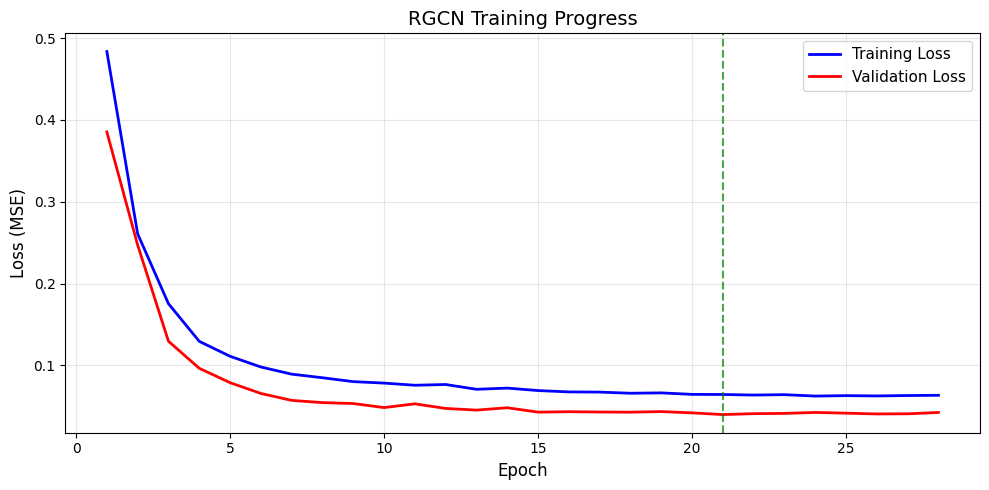

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

epochs = range(1, len(history["train_loss"]) + 1)
ax.plot(epochs, history["train_loss"], 'b-', label='Training Loss', linewidth=2)
ax.plot(epochs, history["val_loss"], 'r-', label='Validation Loss', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_title('RGCN Training Progress', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Mark best epoch
best_epoch = history["val_loss"].index(min(history["val_loss"])) + 1
ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best epoch: {best_epoch}')

plt.tight_layout()
plt.show()


## Final evaluation on validation set


In [29]:
from pathlib import Path
from typing import Dict, Tuple


def evaluate_checkpoint(
    checkpoint_path: Path | str,
    model: nn.Module,
    dataloader: DataLoader,
    horizon: int = FORECAST_HORIZON,
    target_names: list[str] | None = None,
    device: torch.device = device,
) -> Tuple[Dict, torch.Tensor, torch.Tensor, dict]:
    """Load a checkpoint, run evaluation, and return metrics + tensors."""
    checkpoint_path = Path(checkpoint_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found at: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])

    metrics, predictions, targets = evaluate_model(
        model,
        dataloader,
        adj_matrix,
        device,
        target_vars=target_names or TARGET_VARS,
        forecast_horizon=horizon,
    )

    return metrics, predictions, targets, checkpoint


def print_validation_metrics(metrics: dict) -> None:
    """Pretty-print evaluation metrics for each target."""
    print("\n" + "=" * 50)
    print("VALIDATION METRICS")
    print("=" * 50)

    if "Discharge_CMS" in metrics:
        m = metrics["Discharge_CMS"]
        print("\nDischarge_CMS (Regression)")
        print("-" * 30)
        print(f"  MAPE      ≈ {m['MAPE']:.2f}%")
        print(f"  SMAPE     ≈ {m['SMAPE']:.2f}%")
        print(f"  NSE       ≈ {m['NSE']:.4f}")
        print(f"  KGE       ≈ {m['KGE']:.4f}")
        print(f"  RMSE      ≈ {m['RMSE']:.6f}")
        print(f"  Valid obs:  {m['num_valid_obs']:,}")

    if "HoboWetDry0.05" in metrics:
        m = metrics["HoboWetDry0.05"]
        print("\nHoboWetDry0.05 (Classification)")
        print("-" * 30)
        print(f"  Accuracy  ≈ {m['Accuracy']:.4f}")
        print(f"  Precision ≈ {m['Precision']:.4f}")
        print(f"  Recall    ≈ {m['Recall']:.4f}")
        print(f"  F1        ≈ {m['F1']:.4f}")
        print(f"  Valid obs:  {m['num_valid_obs']:,}")

    if "overall" in metrics:
        o = metrics["overall"]
        print("\nOverall")
        print("-" * 30)
        print(f"  Valid observations: {o['total_valid_obs']:,} / {o['total_obs']:,}")
        print(f"  Coverage: {o['coverage']:.2%}")

    print("=" * 50)


# Set this path to whichever checkpoint you want to inspect
CHECKPOINT_TO_EVAL = ckpt_dir / "best_model.pt"

metrics, predictions, targets, checkpoint = evaluate_checkpoint(
    checkpoint_path=CHECKPOINT_TO_EVAL,
    model=model,
    dataloader=val_loader,
    horizon=FORECAST_HORIZON,
    target_names=TARGET_VARS,
    device=device,
)

epoch = checkpoint.get("epoch")
if epoch is not None:
    print(f"Loaded checkpoint '{CHECKPOINT_TO_EVAL}' (epoch {epoch + 1})")
else:
    print(f"Loaded checkpoint '{CHECKPOINT_TO_EVAL}'")

print_validation_metrics(metrics)


Loaded checkpoint '/data/kripat/usgs-gnn/checkpoints/rgcn/best_model.pt' (epoch 21)

VALIDATION METRICS

Discharge_CMS (Regression)
------------------------------
  MAPE      ≈ 1714.26%
  SMAPE     ≈ 94.39%
  NSE       ≈ 0.9155
  KGE       ≈ 0.8619
  RMSE      ≈ 0.334350
  Valid obs:  680

HoboWetDry0.05 (Classification)
------------------------------
  Accuracy  ≈ 0.9912
  Precision ≈ 0.9984
  Recall    ≈ 0.9922
  F1        ≈ 0.9953
  Valid obs:  680

Overall
------------------------------
  Valid observations: 1,360 / 185,562
  Coverage: 0.73%


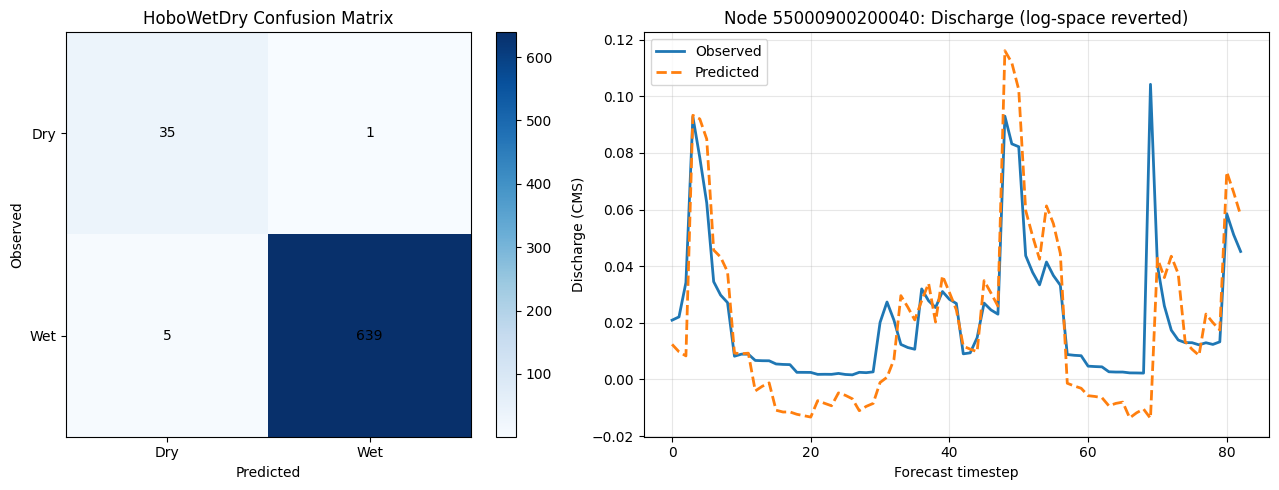

In [30]:
import random
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_and_timeseries(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    target_names: list[str],
    node_id_list: list[int],
    threshold: float = 0.5,
) -> None:
    """Visualize binary confusion + one site's discharge forecast vs truth."""

    preds = predictions.detach().cpu()
    targs = targets.detach().cpu()

    try:
        wetdry_idx = target_names.index("HoboWetDry0.05")
        discharge_idx = target_names.index("Discharge_CMS")
    except ValueError:
        raise ValueError("Target names must include HoboWetDry0.05 and Discharge_CMS")

    # --- Confusion matrix for wet/dry classification ---
    hob_true = targs[..., wetdry_idx]
    hob_pred = preds[..., wetdry_idx]
    mask = ~torch.isnan(hob_true)
    if mask.sum() == 0:
        raise RuntimeError("No valid HoboWetDry0.05 observations to build confusion matrix")

    y_true = hob_true[mask].round().numpy().astype(int)
    y_pred = (hob_pred[mask] >= threshold).numpy().astype(int)

    cm = np.zeros((2, 2), dtype=int)
    np.add.at(cm, (y_true, y_pred), 1)

    # --- One random site's discharge time series (back in linear space) ---
    discharge_true = torch.expm1(targs[..., discharge_idx])
    discharge_pred = torch.expm1(preds[..., discharge_idx])
    node_valid = torch.where(torch.any(~torch.isnan(discharge_true), dim=0))[0]
    if len(node_valid) == 0:
        raise RuntimeError("No valid Discharge_CMS observations available for plotting")

    chosen_idx = random.choice(node_valid.tolist())
    node_mask = ~torch.isnan(discharge_true[:, chosen_idx])
    node_truth = discharge_true[:, chosen_idx][node_mask].numpy()
    node_forecast = discharge_pred[:, chosen_idx][node_mask].numpy()
    times = np.arange(len(node_truth))
    chosen_node_id = node_id_list[chosen_idx]

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    im = axes[0].imshow(cm, cmap="Blues")
    axes[0].set_xticks([0, 1], labels=["Dry", "Wet"])
    axes[0].set_yticks([0, 1], labels=["Dry", "Wet"])
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Observed")
    axes[0].set_title("HoboWetDry Confusion Matrix")
    for i in range(2):
        for j in range(2):
            axes[0].text(j, i, cm[i, j], ha="center", va="center", color="black")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    axes[1].plot(times, node_truth, label="Observed", linewidth=2)
    axes[1].plot(times, node_forecast, label="Predicted", linewidth=2, linestyle="--")
    axes[1].set_title(f"Node {chosen_node_id}: Discharge (log-space reverted)")
    axes[1].set_xlabel("Forecast timestep")
    axes[1].set_ylabel("Discharge (CMS)")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_confusion_and_timeseries(
    predictions=predictions,
    targets=targets,
    target_names=TARGET_VARS,
    node_id_list=node_ids,
)

